# Normalisation - Équilibre du dataset
## Objectif
L'objectif de ce notebook est de tester l'équilibre du jeu de données d'entraînement afin de voir s'il peut y avoir un impact positif. Pour cela nous allons essayer de mettre 2000 images de radio "NORMAL" contre 5000 images de radio "PNEUMONIA" afin de voir si cela peut améliorer les résultats du CNN.

## Hypothèses
Les hypothèses quant aux résultats attendus sont les suivants :
- Une moins bonne précision que celui du CNN
- Moins de faux négatifs et plus de vrais positifs

## Etapes de la démarche
1. Modifier la condition de chargement des images
2. Tester le modèle sur le jeu de données
3. Calculer les métriques de performance
4. Comparer les résultats avec les résultats du CNN

## Conclusion
Les résultats obtenus sont les suivants :
- Une moins bonne précision que celui du CNN
- Moins de faux négatifs et plus de vrais positifs

Les résultats sont en accord avec l'hypothèse de départ. Le fait de réduire le nombre d'images de la classe "NORMAL" a permis d'améliorer la détection de la classe "PNEUMONIA" mais a dégradé la détection de la classe "NORMAL". Cela est dû au fait que le CNN a été entraîné sur un jeu de données équilibré. Il est donc normal que le modèle soit moins performant.


In [88]:
# Check that GPU is used
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [89]:
from PIL import Image
import os
import numpy as np

# Define the folders where your data is stored
train_folder = 'train'
test_folder = 'test'
val_folder = 'val'

# Define the subfolders within each folder where the images are stored
subfolders = ['NORMAL', 'PNEUMONIA']

# Define the size of the images you want to resize your images to
img_width, img_height = 128, 128 # Function to load and resize images from a folder

In [90]:
# Function to load and resize images from a folder
def load_images_from_folder(folder, limit_per_subfolder=None):
    X = []
    y = []
    for subfolder in subfolders:
        folder_path = os.path.join(folder, subfolder)
        if limit_per_subfolder:
            # Get amount of random filenames from the folder
            if subfolder == 'NORMAL':
                limit = min(limit_per_subfolder, len(os.listdir(folder_path)))
            else:
                limit = min(5000, len(os.listdir(folder_path)))
            filenames = np.random.choice(os.listdir(folder_path), limit, replace=False)
        else:
            filenames = os.listdir(folder_path)
        for filename in filenames:
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)

            # Resize the image to the desired size
            img = img.resize((img_width, img_height))

            # Convert RGB image to grayscale
            img = img.convert('L')

            # Convert the image to a NumPy array and append it to X
            img = np.array(img)
            X.append(img)

            # Append the corresponding label to y
            y.append(subfolders.index(subfolder))

    X = np.array(X)
    y = np.array(y)
    return X, y


In [91]:
# Generate augmented for the training set
from data_augmentation import generate_augmented_images
generate_augmented_images(train_folder, 'NORMAL', image_size=(img_width, img_height))
generate_augmented_images(train_folder, 'PNEUMONIA', image_size=(img_width, img_height))

Found 1341 images belonging to 1 classes.
Additional count of images to generate: 0
Given NORMAL count: 1341
Augmented NORMAL count: 5000
Found 3875 images belonging to 1 classes.
Additional count of images to generate: 0
Given PNEUMONIA count: 3875
Augmented PNEUMONIA count: 5000


In [92]:
# Load the training data
# Get min value between the number of normal images and the number of pneumonia images
train_folder = f"{train_folder}_augmented"
min_images = 2000
X_train, y_train = load_images_from_folder(train_folder, min_images)

# Load the test data
X_test, y_test = load_images_from_folder(test_folder)

# Load the validation data
X_val, y_val = load_images_from_folder(val_folder)

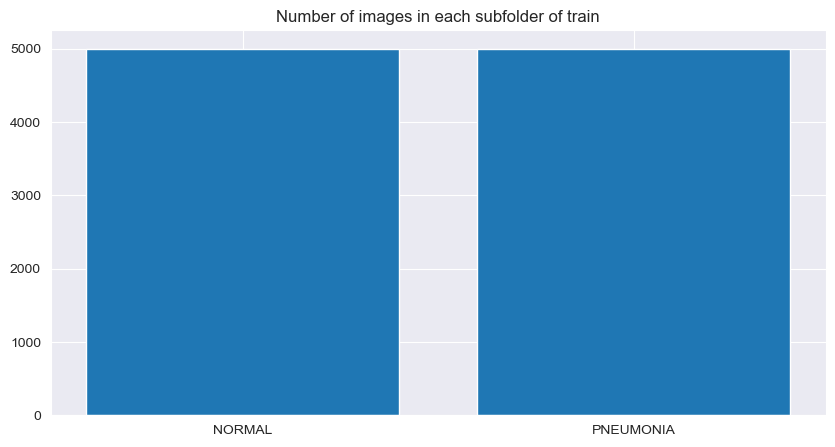

In [93]:
# Make a matplot figure to show how many images are in each subfolder of train
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.bar(subfolders, [len(os.listdir(os.path.join(train_folder, subfolder))) for subfolder in subfolders])
plt.title('Number of images in each subfolder of train')
plt.show()

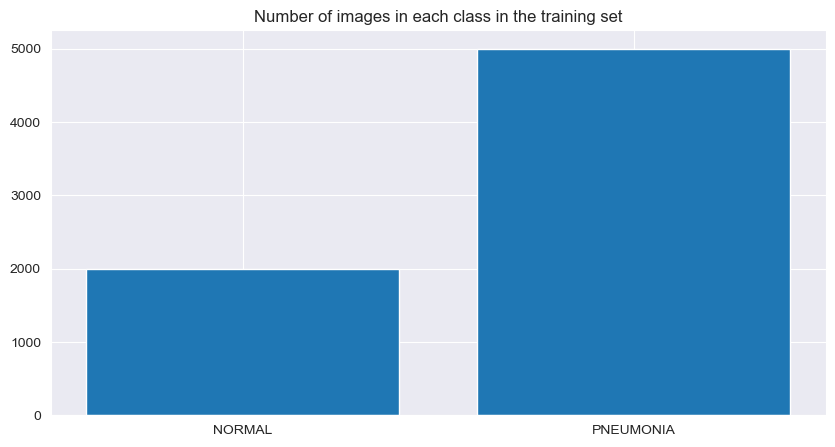

In [94]:
# Make a matplot figure to show how many images if each class in the training set
plt.figure(figsize=(10, 5))
plt.bar(subfolders, [len(y_train[y_train == i]) for i in range(len(subfolders))])
plt.title('Number of images in each class in the training set')
plt.show()

In [95]:
# Normalize the pixel values to be between 0 and 1
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_val = X_val.astype('float32') / 255

X_train = X_train.reshape(len(X_train), img_width, img_height, 1)
X_test = X_test.reshape(len(X_test), img_width, img_height, 1)
X_val = X_val.reshape(len(X_val), img_width, img_height, 1)

(128, 128, 1)


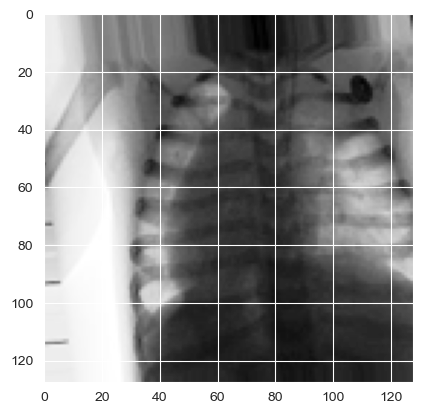

In [96]:
single_image = X_train[np.random.randint(len(X_train))]
print(single_image.shape)
plt.imshow(single_image, cmap='Greys')

In [97]:
# Define model metrics
from keras.metrics import AUC

metrics = [
    "accuracy",
    AUC(name='auc')
]

In [98]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model architecture
def create_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(img_width, img_height, 1), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=256, kernel_size=(3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())

    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))

    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation="sigmoid"))

    # compile the model
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=metrics)

    return model

In [99]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

In [100]:
# Cross validation
from sklearn.model_selection import KFold
from keras.preprocessing.image import ImageDataGenerator

# Define the number of folds for cross-validation
n_splits = 10
epochs = 7

# Initialize KFold with the number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define lists to store the evaluation scores for each fold
accuracy_scores = []
histories = []
models = []

# Iterate through each fold and train/evaluate the model
for train_idx, val_idx in kf.split(X_train, y_train):
    # Split the data into training and validation sets for this fold
    X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
    X_val_fold, y_val_fold = X_train[val_idx], y_train[val_idx]

    # Create an instance of ImageDataGenerator to generate your image data
    datagen = ImageDataGenerator()

    # Create generators for training and validation data
    train_generator = datagen.flow(x=X_train_fold, y=y_train_fold, batch_size=64)
    valid_generator = datagen.flow(x=X_val_fold, y=y_val_fold, batch_size=64)

    # Create instance of the model for this fold and train it
    model = create_model()

    # Train your model on the training data for this fold
    history = model.fit(train_generator, validation_data=valid_generator, epochs=epochs, verbose=1, callbacks=[early_stop])
    histories.append(history.history)

    models.append(model)


Epoch 1/7
99/99 [==============================] - 13s 84ms/step - loss: 0.4928 - accuracy: 0.7670 - auc: 0.7604 - val_loss: 0.2844 - val_accuracy: 0.8843 - val_auc: 0.9451
Epoch 2/7
99/99 [==============================] - 6s 58ms/step - loss: 0.3176 - accuracy: 0.8644 - auc: 0.9231 - val_loss: 0.2806 - val_accuracy: 0.8829 - val_auc: 0.9507
Epoch 3/7
99/99 [==============================] - 6s 57ms/step - loss: 0.2701 - accuracy: 0.8905 - auc: 0.9441 - val_loss: 0.2177 - val_accuracy: 0.9000 - val_auc: 0.9708
Epoch 4/7
99/99 [==============================] - 6s 58ms/step - loss: 0.2454 - accuracy: 0.9021 - auc: 0.9545 - val_loss: 0.2124 - val_accuracy: 0.8986 - val_auc: 0.9757
Epoch 5/7
99/99 [==============================] - 6s 57ms/step - loss: 0.2250 - accuracy: 0.9094 - auc: 0.9623 - val_loss: 0.2027 - val_accuracy: 0.9214 - val_auc: 0.9752
Epoch 6/7
99/99 [==============================] - 6s 57ms/step - loss: 0.1971 - accuracy: 0.9232 - auc: 0.9697 - val_loss: 0.1831 - val_ac

In [101]:
# Get accuracy scores for each fold (train and validation)
loss = []
acc = []
val_loss = []
val_acc = []

for history in histories:
    loss.append(np.mean(history["loss"]))
    acc.append(np.mean(history["accuracy"]))
    val_loss.append(np.mean(history["val_loss"]))
    val_acc.append(np.mean(history["val_accuracy"]))

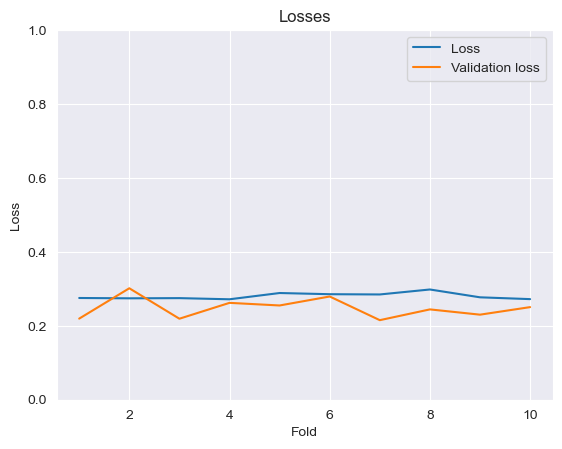

In [102]:
# Plot loss and validation loss per fold
import matplotlib.pyplot as plt
plt.title('Losses')
plt.plot(range(1, len(loss)+1), loss, label='Loss')
plt.plot(range(1, len(val_loss)+1), val_loss, label='Validation loss')
plt.ylim(0.0, 1.0)
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend()
plt.show()

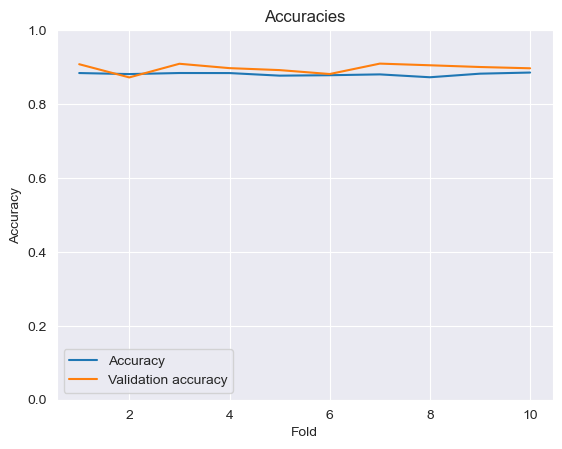

In [103]:
# Plot accuracies and validation accuracies per fold
import matplotlib.pyplot as plt
plt.title('Accuracies')
plt.plot(range(1, len(acc)+1), acc, label='Accuracy')
plt.plot(range(1, len(val_acc)+1), val_acc, label='Validation accuracy')
plt.ylim(0.0, 1.0)
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [104]:
# Train a final model with same parameters and save it
train_generator = datagen.flow(x=X_train, y=y_train, batch_size=64)
valid_generator = datagen.flow(x=X_val, y=y_val, batch_size=64)
model = create_model()
history = model.fit(train_generator, validation_data=valid_generator, epochs=epochs, verbose=1, callbacks=[early_stop])
model.save('cnn.h5')

Epoch 1/7
110/110 [==============================] - 10s 70ms/step - loss: 0.5461 - accuracy: 0.7316 - auc: 0.7318 - val_loss: 0.7488 - val_accuracy: 0.5625 - val_auc: 0.8047
Epoch 2/7
110/110 [==============================] - 6s 56ms/step - loss: 0.3101 - accuracy: 0.8721 - auc: 0.9271 - val_loss: 0.9367 - val_accuracy: 0.6875 - val_auc: 0.7500
Epoch 3/7
110/110 [==============================] - 6s 57ms/step - loss: 0.2805 - accuracy: 0.8849 - auc: 0.9412 - val_loss: 0.4179 - val_accuracy: 0.8125 - val_auc: 0.9453
Epoch 4/7
110/110 [==============================] - 6s 59ms/step - loss: 0.2456 - accuracy: 0.9019 - auc: 0.9545 - val_loss: 0.7639 - val_accuracy: 0.6875 - val_auc: 0.8984
Epoch 5/7
110/110 [==============================] - 6s 57ms/step - loss: 0.2261 - accuracy: 0.9110 - auc: 0.9618 - val_loss: 0.6007 - val_accuracy: 0.6875 - val_auc: 0.9688
Epoch 6/7
110/110 [==============================] - 6s 57ms/step - loss: 0.1968 - accuracy: 0.9239 - auc: 0.9695 - val_loss: 0.3

In [105]:
from keras.saving.save import load_model

model = load_model("cnn.h5")

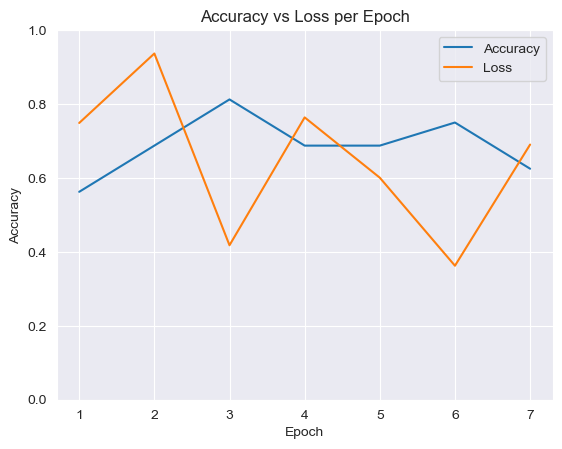

In [106]:
# Plot val accuracy and val loss of the trained model
import matplotlib.pyplot as plt
plt.title('Accuracy vs Loss per Epoch')
plt.plot(range(1, len(history.history["val_accuracy"])+1), history.history["val_accuracy"], label='Accuracy')
plt.plot(range(1, len(history.history["val_loss"])+1), history.history["val_loss"], label='Loss')
plt.ylim(0.0, 1.0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [107]:
# Make predictions on the test set
y_pred_test = model.predict(X_test)
y_pred_test = np.where(y_pred_test >= 0.5, 1, 0)

20/20 [==============================] - 0s 10ms/step


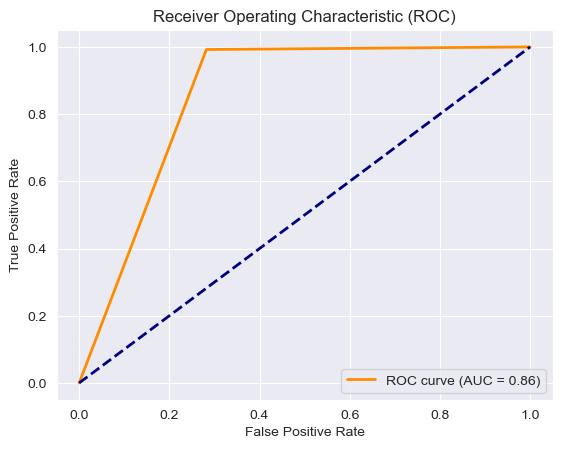

In [108]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and AUC score for the predictions
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)

# Plot ROC curve and show AUC score on the plot
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [109]:
from sklearn.metrics import confusion_matrix
# Compute the confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test.flatten())
print(cm)

[[168  66]
 [  3 387]]


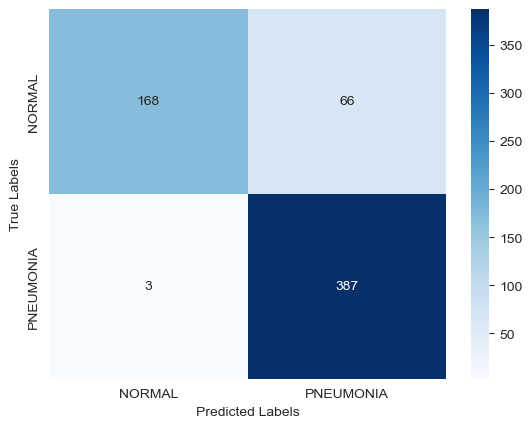

In [110]:
# Plot the confusion matrix
class_names = subfolders
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [111]:
# Compute the classification report for test set
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_test, target_names=class_names))

              precision    recall  f1-score   support

      NORMAL       0.98      0.72      0.83       234
   PNEUMONIA       0.85      0.99      0.92       390

    accuracy                           0.89       624
   macro avg       0.92      0.86      0.87       624
weighted avg       0.90      0.89      0.88       624



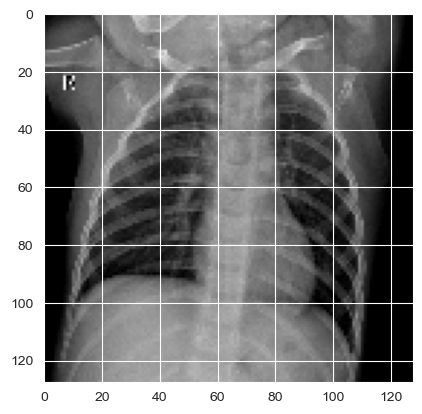

C:\Users\nathp\anaconda3\lib\site-packages\keras\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


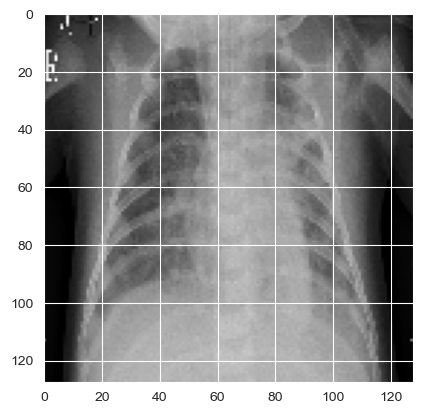

In [112]:
# Heatmaps and Grad-CAM
from cam import get_img_array
import cv2
import matplotlib.pyplot as plt 

images = [
    {
        "path": "./val/NORMAL/NORMAL2-IM-1442-0001.jpeg"
    },
    {
        "path": "./val/PNEUMONIA/person1946_bacteria_4874.jpeg"
    }
]

for image in images:
    image_temp = cv2.imread(image["path"])
    image_temp = cv2.cvtColor(image_temp, cv2.COLOR_RGB2GRAY)
    image_temp = cv2.resize(image_temp, (img_width, img_height))

    plt.imshow(image_temp, cmap=plt.cm.gray)
    plt.show()
    
    image["array"] = get_img_array(image["path"], size=(img_width, img_height))
    

In [113]:
# Remove last layer's softmax
model.layers[-1].activation = None

# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [114]:
# Print model summary to get last max pooling layer name
print(model.summary())

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_128 (Conv2D)         (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_128 (MaxPooli  (None, 63, 63, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_129 (Conv2D)         (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_129 (MaxPooli  (None, 30, 30, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_130 (Conv2D)         (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_130 (MaxPooli  (None, 14, 14, 128)    

In [118]:
# Select last conv layer
last_conv_layer_name = "max_pooling2d_131"

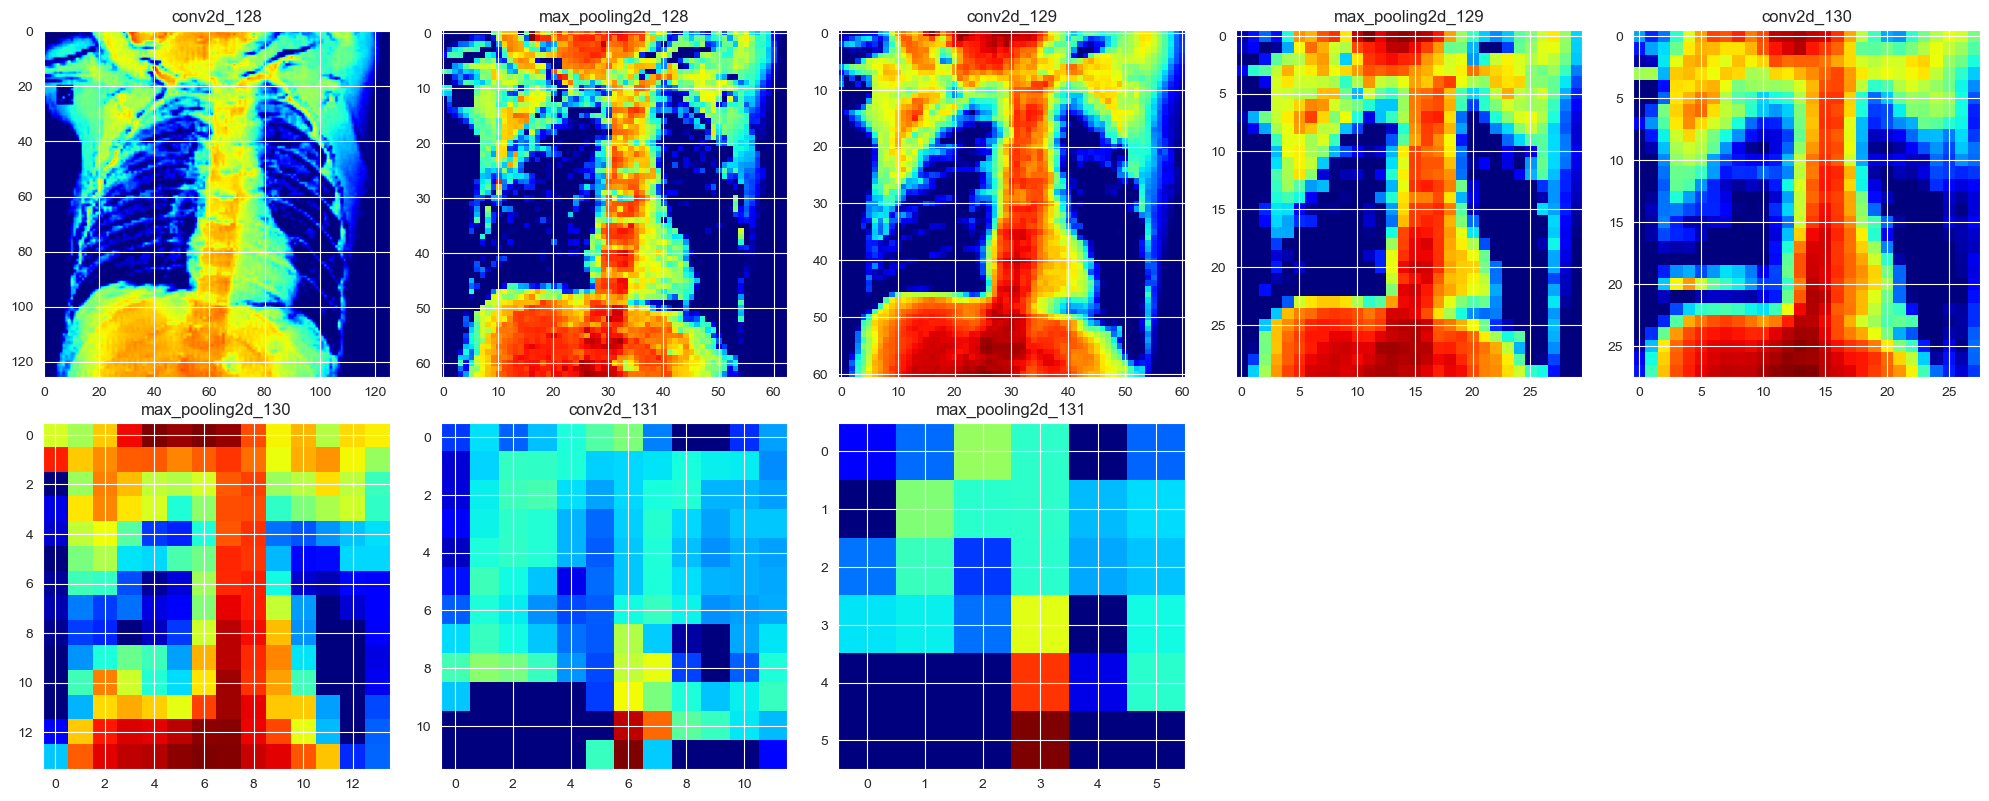

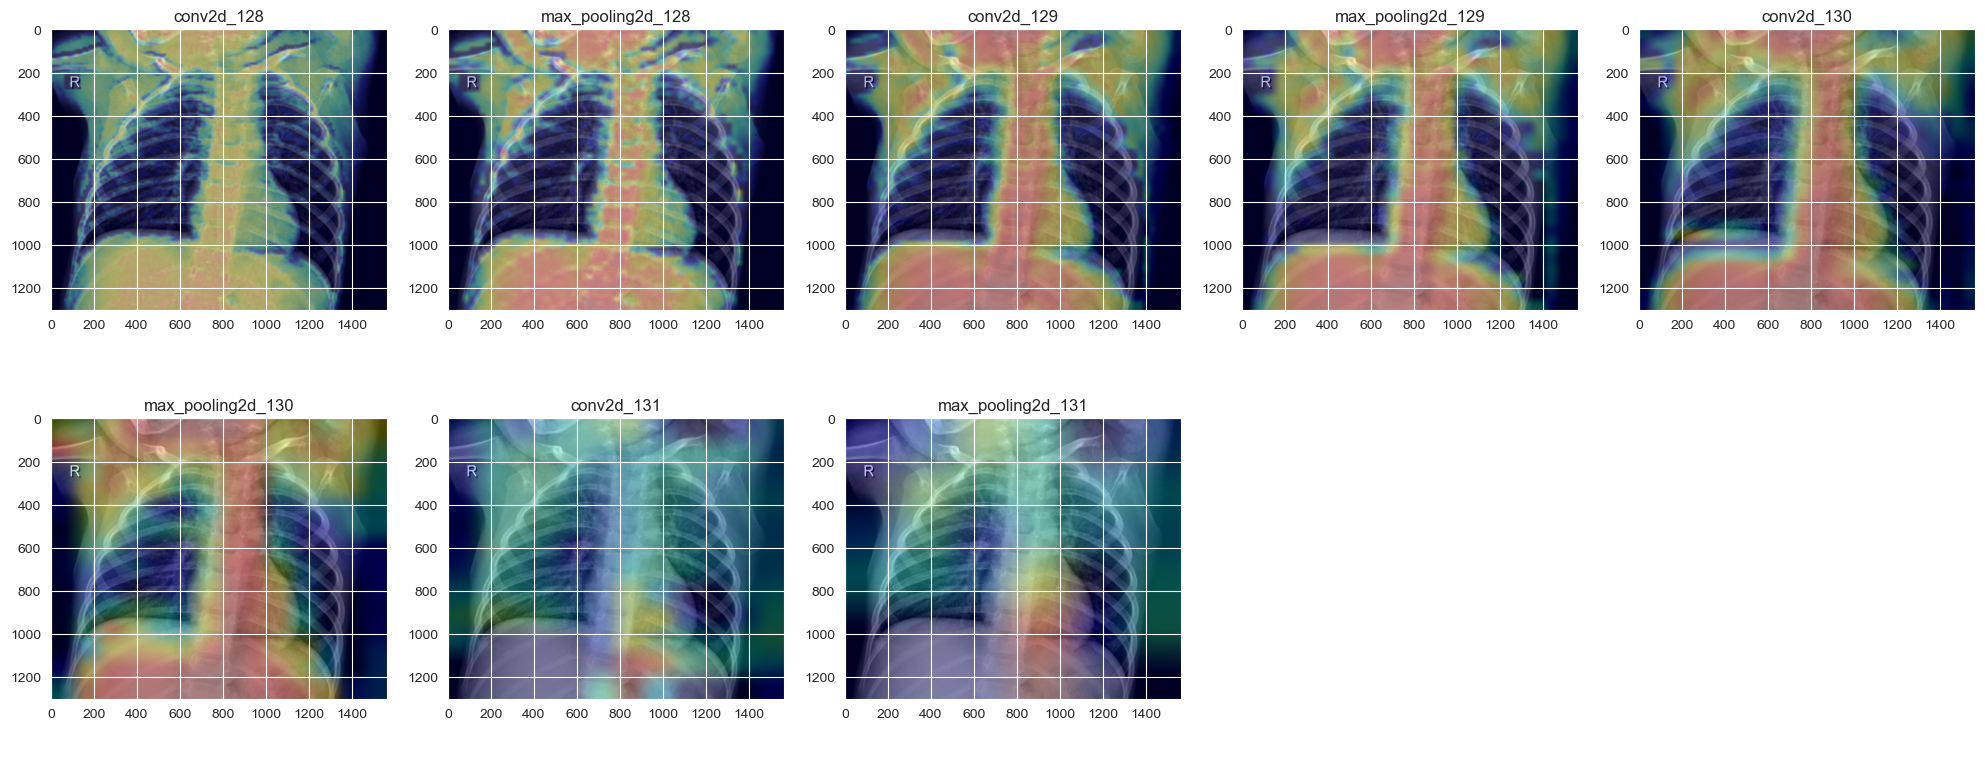

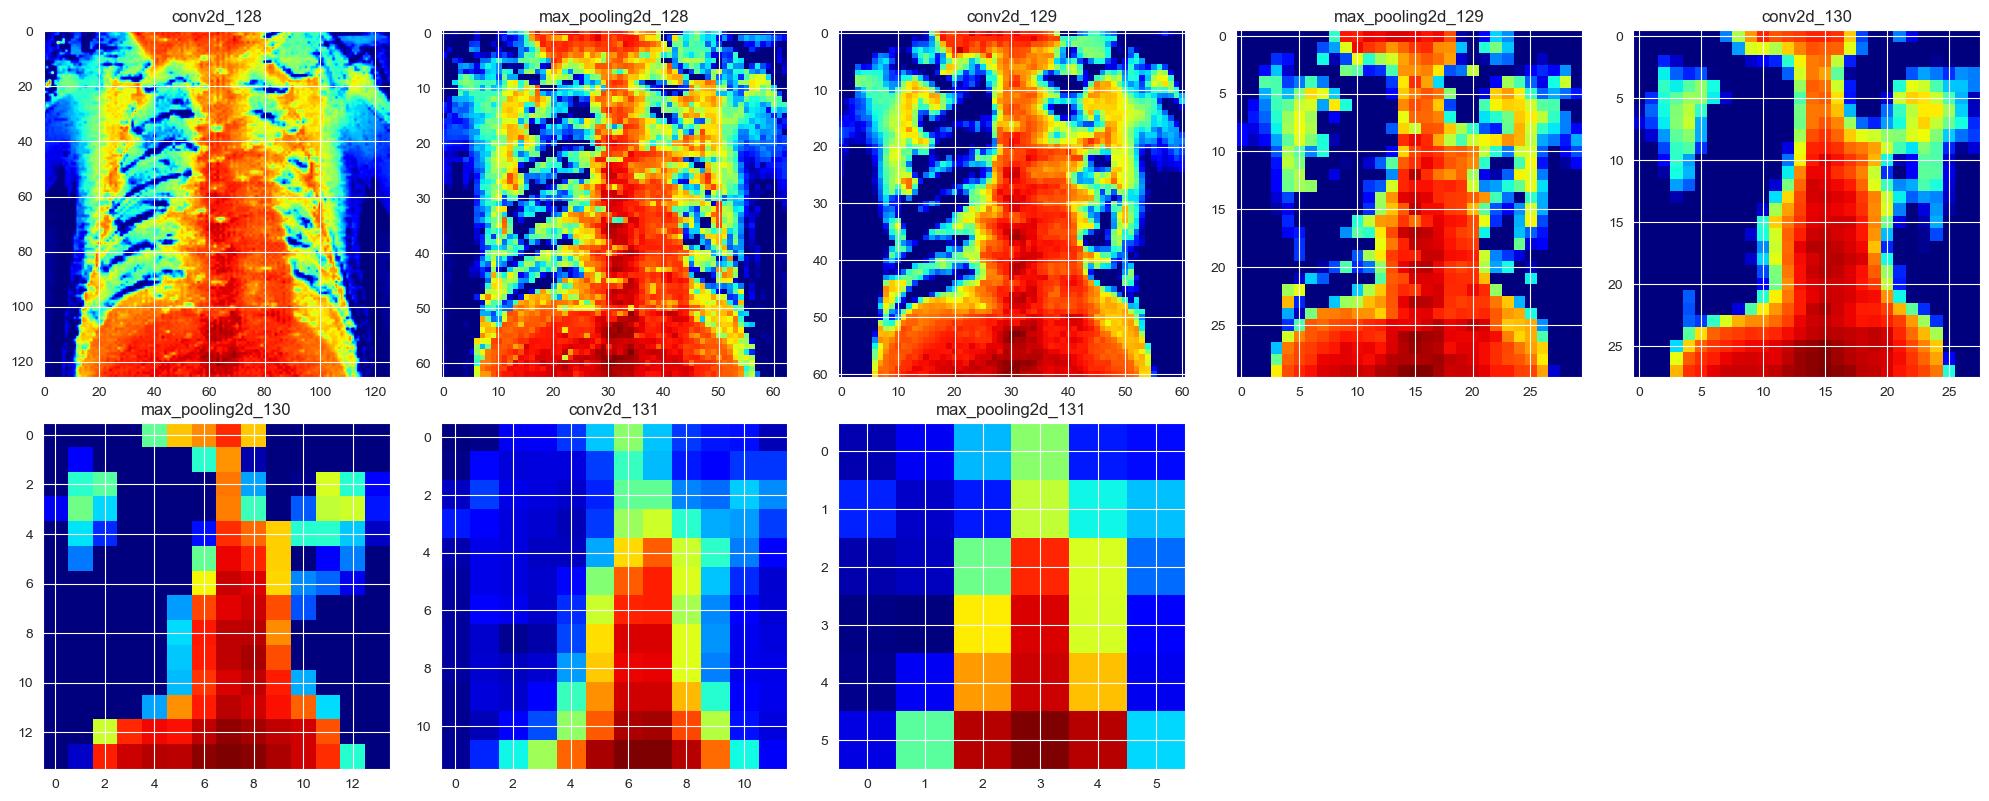

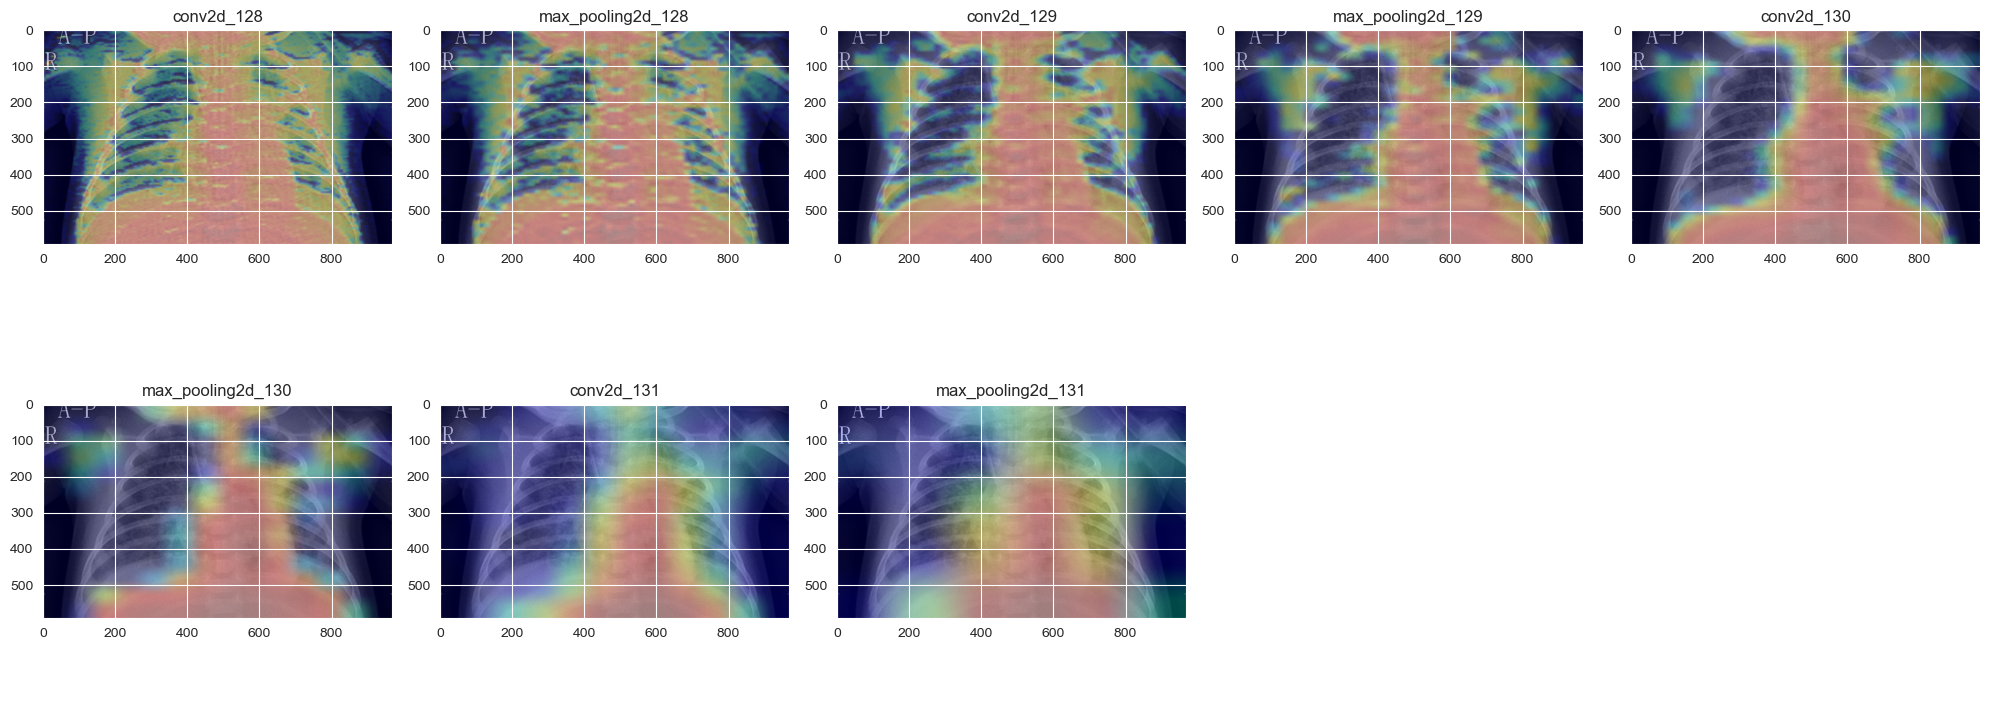

In [119]:
from cam import make_gradcam_heatmap, display_heatmaps

for image in images:
    heatmaps = []
    for layer in model.layers[:model.layers.index(model.get_layer(last_conv_layer_name)) + 1]:
        heatmap = make_gradcam_heatmap(image["array"], model, layer.name)
        heatmaps.append({
            "layer_name": layer.name,
            "image": heatmap
        })

    # Display heatmaps from all layers until the last max pooling layer
    display_heatmaps(image["path"], heatmaps)

    # Display the chosen image superimposed with heatmaps of each layer until the last max pooling layer
    display_heatmaps(image["path"], heatmaps, True)

In [120]:
# Predict
for image in images:
    pred = model.predict(image["array"].reshape(1, img_width, img_height, 1))
    print(pred)
    # Display predicted class
    print("Predicted class: {}".format(subfolders[int(pred[0][0])]))

1/1 [==============================] - 0s 33ms/step
[[0.]]
Predicted class: NORMAL
1/1 [==============================] - 0s 47ms/step
[[1.]]
Predicted class: PNEUMONIA
